In [222]:
# 1. Definição do problema de negócio 

## Projeto: Previsão de Risco de Inadimplência

Este projeto visa construir um modelo de *credit scoring* para prever a probabilidade de um cliente se tornar inadimplente nos próximos dois anos, utilizando dados históricos para otimizar a concessão de crédito e minimizar perdas financeiras.

* **Fonte de Dados:** [Give Me Some Credit :: 2011 Competition Data](https://www.kaggle.com/c/GiveMeSomeCredit) do Kaggle.

In [223]:
# 2. Carregamento e Exploração Inicial dos Dados

Nesta etapa, iniciamos a fase de análise conectando nosso ambiente Python ao banco de dados SQLite que foi populado anteriormente. O objetivo é carregar os dados para um DataFrame do `pandas`, que é a estrutura de dados fundamental para manipulação e análise em Data Science.

Utilizaremos a biblioteca `sqlite3` para a conexão e `pandas` para executar a query SQL e armazenar os resultados. Após o carregamento, faremos duas verificações essenciais:

1.  **`df.head()`**: Para inspecionar as primeiras linhas do DataFrame, garantindo que os dados foram carregados corretamente e para termos uma primeira impressão da estrutura e dos valores.
2.  **`df.info()`**: Para obter um resumo técnico do DataFrame, incluindo o tipo de dado de cada coluna, a contagem de valores não nulos e o uso de memória. Esta etapa é crucial para identificar problemas como tipos de dados incorretos e, principalmente, **a presença de valores ausentes (NaN)**, que precisarão ser tratados na fase de limpeza.

In [224]:
# Imports
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [225]:
# Nome do banco de dados criado
NOME_BANCO_DE_DADOS = 'analise_de_credito.db'

# Conecta ao banco de dados
conn = sqlite3.connect(NOME_BANCO_DE_DADOS)

# Query SQL para selecionar todos os dados da nossa tabela
query = "SELECT * FROM clientes_credito"

# Executa a query e carrega os dados em um DataFrame
df = pd.read_sql_query(query, conn)

# Fecha a conexão
conn.close()

print("Dados carregados do banco de dados com sucesso!")

# Exibe as 5 primeiras linhas para ver se está tudo certo
print("\nPré-visualização dos dados:")
display(df.head())

# Exibe informações sobre as colunas e valores nulos
print("\nInformações do DataFrame:")
df.info()

Dados carregados do banco de dados com sucesso!

Pré-visualização dos dados:


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0



Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146

In [ ]:
# 3. Preparação dos dados

In [227]:
# 3.1. Utilização de um dicionário para renomar as variaveis

Nessa terceira etapa será criado um dicionário para mapeamento da coluna head, isto é, com o nome das variáveis, para melhorar a visualização dos dados.

In [228]:
# Criamos um dicionário para mapear os nomes antigos para os novos
mapa_nomes = {
    'SeriousDlqin2yrs': 'inadimplente_2_anos',
    'RevolvingUtilizationOfUnsecuredLines': 'utilizacao_credito_rotativo',
    'age': 'idade',
    'NumberOfTime30-59DaysPastDueNotWorse': 'atraso_30_59_dias',
    'DebtRatio': 'razao_divida',
    'MonthlyIncome': 'renda_mensal',
    'NumberOfOpenCreditLinesAndLoans': 'linhas_credito_abertas',
    'NumberOfTimes90DaysLate': 'atraso_90_dias_ou_mais',
    'NumberRealEstateLoansOrLines': 'num_emprestimos_imobiliarios',
    'NumberOfTime60-89DaysPastDueNotWorse': 'atraso_60_89_dias',
    'NumberOfDependents': 'num_dependentes'
}

# Usamos o método .rename() para aplicar o mapa de nomes
df = df.rename(columns=mapa_nomes)

# Verificamos o resultado
print("Colunas renomeadas com sucesso!")
print(df.columns.tolist())

Colunas renomeadas com sucesso!
['inadimplente_2_anos', 'utilizacao_credito_rotativo', 'idade', 'atraso_30_59_dias', 'razao_divida', 'renda_mensal', 'linhas_credito_abertas', 'atraso_90_dias_ou_mais', 'num_emprestimos_imobiliarios', 'atraso_60_89_dias', 'num_dependentes']


Foi observado que a variável `MonthlyIncome` apresentou quase 30000 valores de renda faltando. Como a distribuição de renda geralmente é assimétrica, a média seria um parâmetro distorcido para tratar os valores faltantes, dessa forma, a mediana seria o melhor parâmetro a ser utilizado, pois não é afetado por valores extremos, representando melhor um cliente "típico".
Já a variável `NumberOfDependents` apresentou cerca de 4000 valores faltando. A estratégia será preencher os valores ausentes com a moda, isto é, o valor mais frequente no banco de dados. Como o número de dependentes é uma quantidade discreta e inteira, preencher com o valor mais comum é a abordagem mais lógica e segura. 

- O tratamento dos valores faltantes não será realizado nessa etapa. Na modelagem será utilizado os parâmetros mencionados para a imputação na criação do pipeline para evitar o data leakage.

In [229]:
# 4. Análise exploratória dos dados (EDA)

In [230]:
# 4.1. Verificação dos parâmetros

Nessa etapa será criado um loop para iterar por cada linha das colunas para melhor visualização dos parâmetros de cada variável no banco de dados.

In [231]:
# Itera por cada coluno no df
for coluna in df.columns:
    print(f"--- Descrição da Variável: {coluna} ---")
    print(df[coluna].describe())
    print("\n" + "="*40 + "\n") 

--- Descrição da Variável: inadimplente_2_anos ---
count    150000.000000
mean          0.066840
std           0.249746
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: inadimplente_2_anos, dtype: float64


--- Descrição da Variável: utilizacao_credito_rotativo ---
count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: utilizacao_credito_rotativo, dtype: float64


--- Descrição da Variável: idade ---
count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: idade, dtype: float64


--- Descrição da Variável: atraso_30_59_dias ---
count    150000.000000
mean          0.421033
std           4.192781
min           0.000000
25%           0.000000
50%        

In [232]:
# 4.2. Relação das variáveis

Qual a proporção de clientes adimplentes vs. inadimplentes?

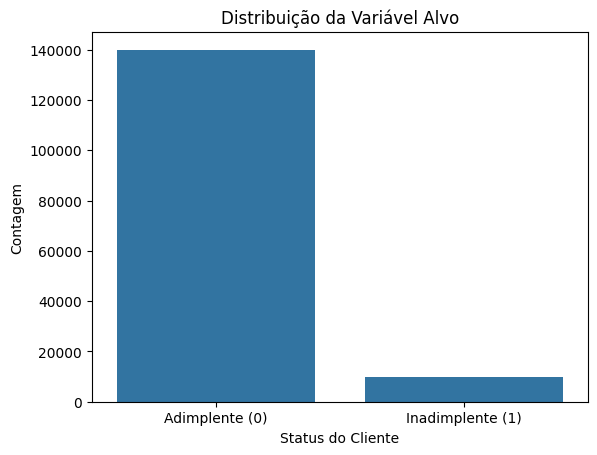

In [233]:
# Gráfico de barras
ax = sns.countplot(data=df, x='inadimplente_2_anos')

# Correção: Defina as posições dos ticks e depois os rótulos
ax.set_xticks([0, 1])
ax.set_xticklabels(['Adimplente (0)', 'Inadimplente (1)'])

plt.title('Distribuição da Variável Alvo')
plt.ylabel('Contagem')
plt.xlabel('Status do Cliente')
plt.show()

Observa-se que a proporção de adimplente (0) é de aproximadamente 93%, enquanto de inadimplente é de cerca de 7%. Dessa forma, a variável alvo `inadimplente_2_anos` mostrou ser uma variável desbalanceada. 

In [234]:
# 4.3. Atraso e inadimplência

Vamos agora focar nas colunas que descrevem o histórico de pagamentos em atraso do cliente, que são fortes candidatas a preditoras de inadimplência. As colunas são: `atraso_30_59_dias`, `atraso_60_89_dias` e `atraso_90_dias_ou_mais`.

--- Contagem de valores para: atraso_30_59_dias ---
atraso_30_59_dias
0    126018
1     16033
2      4598
3      1754
4       747
Name: count, dtype: int64
----------------------------------------
--- Contagem de valores para: atraso_60_89_dias ---
atraso_60_89_dias
0     142396
1       5731
2       1118
3        318
98       264
Name: count, dtype: int64
----------------------------------------
--- Contagem de valores para: atraso_90_dias_ou_mais ---
atraso_90_dias_ou_mais
0    141662
1      5243
2      1555
3       667
4       291
Name: count, dtype: int64
----------------------------------------


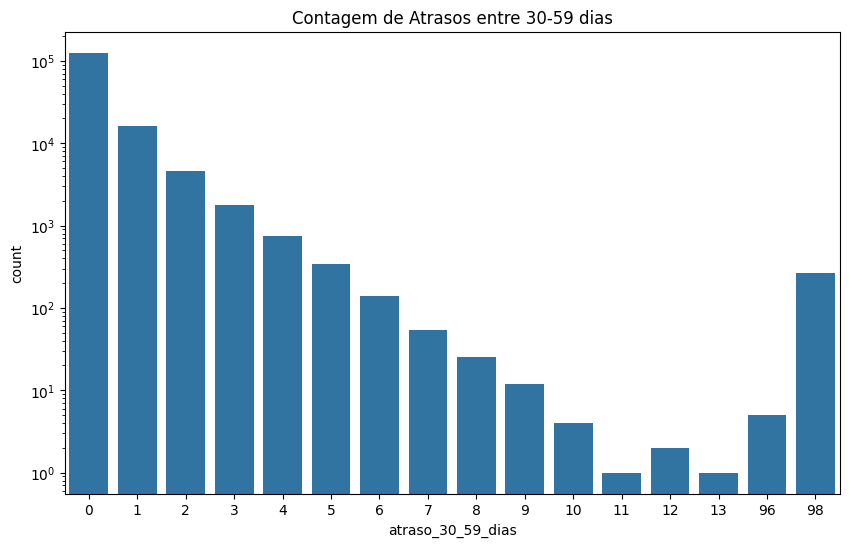

In [235]:
colunas_atraso = ['atraso_30_59_dias', 
                 'atraso_60_89_dias', 
                 'atraso_90_dias_ou_mais']

# Mostra a contagem de valores para cada tipo de atraso
for col in colunas_atraso:
    print(f"--- Contagem de valores para: {col} ---")
    print(df[col].value_counts().head()) # .head() para ver os mais comuns
    print("-" * 40)

# Gráfico de contagem para o atraso mais comum (30-59 dias)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='atraso_30_59_dias')
plt.title('Contagem de Atrasos entre 30-59 dias')
plt.yscale('log') # Escala logarítmica para ver melhor os valores pequenos
plt.show()

Pontos a serem observados:
1. Contagem de Valores:
    A contagem de valores para as três colunas mostra um padrão claro: a esmagadora maioria dos registros possui o valor 0. Isso indica que a maior parte dos clientes na base de dados não apresentou atrasos nessas faixas de tempo específicas. Essa alta concentração em um único valor é um ponto de atenção para a modelagem.

2. Visualização da Distribuição (atraso_30_59_dias):
    O gráfico de barras nos ajuda a visualizar a distribuição dessa contagem.

Uso da Escala Logarítmica: Foi fundamental utilizar a escala logarítmica (plt.yscale('log')) no eixo vertical. Sem ela, a barra do valor 0 seria tão desproporcionalmente alta que todas as outras contagens seriam achatadas e ficariam invisíveis.

In [236]:
# 4.4. Análise de correlação entre as variáveis

Para aprofundar o entendimento sobre a relação entre as variáveis, será realizada uma análise de correlação. 

Os objetivos principais são:

1.  **Identificar Preditores Relevantes:** Verificar quais variáveis possuem a maior correlação (positiva ou negativa) com a nossa variável-alvo (`inadimplente_2_anos`). Variáveis com alta correlação são, geralmente, bons preditores para o modelo de machine learning.

2.  **Detectar Multicolinearidade:** Analisar a correlação **entre as variáveis preditoras**. Uma alta correlação entre duas features indica que elas carregam informações redundantes. Isso é importante saber, pois alguns modelos podem ser sensíveis a esse fenômeno.

Para visualizar essas relações, será utilizado um **heatmap** da matriz de correlação de Pearson. As cores quentes (vermelho/laranja) indicam uma correlação positiva (quando uma variável sobe, a outra também tende a subir), enquanto as cores frias (azul) indicam uma correlação negativa (quando uma sobe, a outra tende a descer). Para tornar o gráfico mais limpo, aplicamos uma máscara para ocultar a parte superior da matriz, que é redundante.

Abaixo do gráfico, será também gerada uma lista ordenada para quantificar a força exata da correlação de cada variável com a nossa variável-alvo.

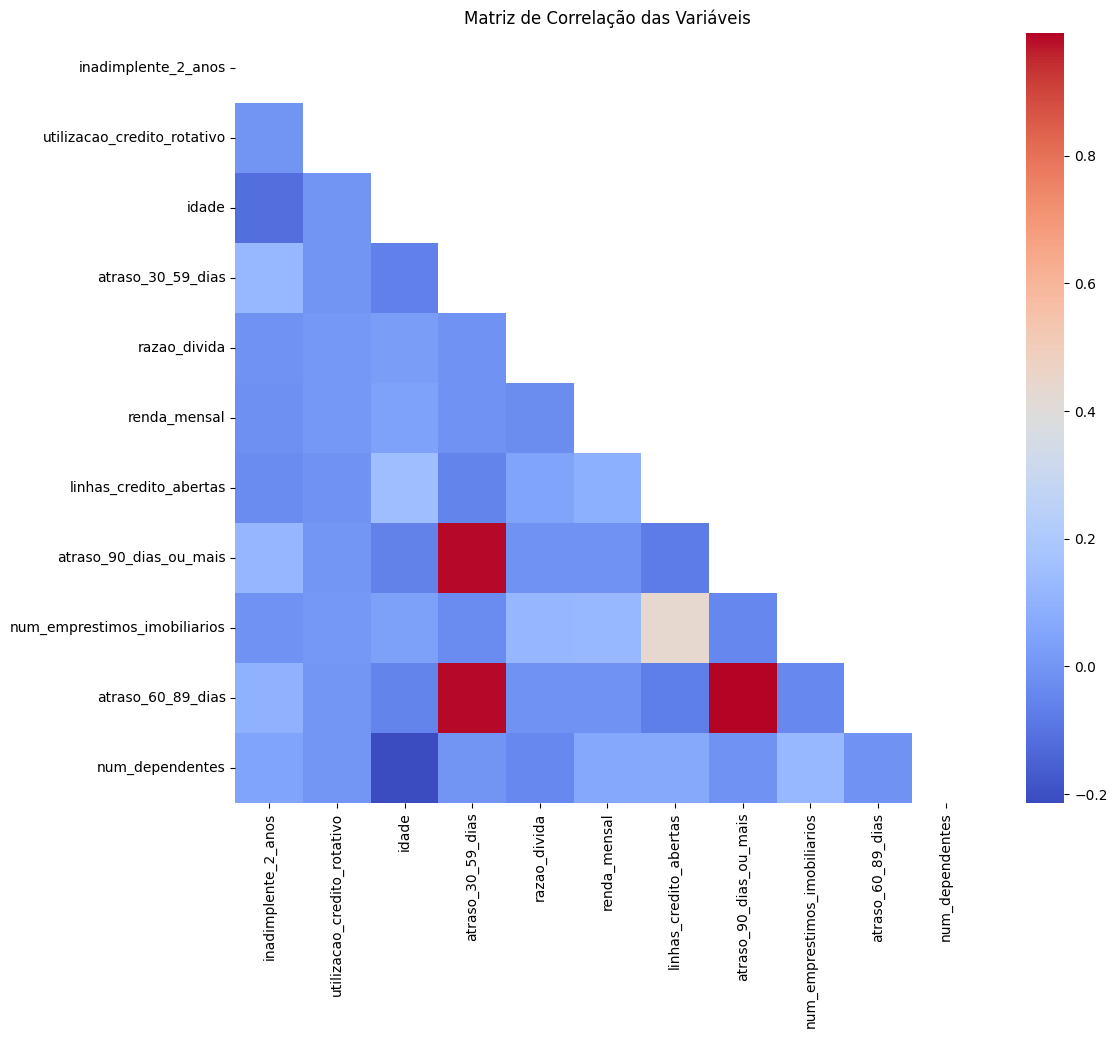


Correlação com a variável alvo ('inadimplente_2_anos'):
inadimplente_2_anos             1.000000
atraso_30_59_dias               0.125587
atraso_90_dias_ou_mais          0.117175
atraso_60_89_dias               0.102261
num_dependentes                 0.046048
utilizacao_credito_rotativo    -0.001802
num_emprestimos_imobiliarios   -0.007038
razao_divida                   -0.007602
renda_mensal                   -0.019746
linhas_credito_abertas         -0.029669
idade                          -0.115386
Name: inadimplente_2_anos, dtype: float64


In [237]:
plt.figure(figsize=(12, 10))

# Calcula a matriz de correlação
correlation_matrix = df.corr()

# Cria uma máscara para mostrar apenas a parte de baixo da matriz (evita redundância)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plota o heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm') # annot=False para não poluir
plt.title('Matriz de Correlação das Variáveis')
plt.show()

# Para ver os valores exatos de correlação com o alvo:
print("\nCorrelação com a variável alvo ('inadimplente_2_anos'):")
print(correlation_matrix['inadimplente_2_anos'].sort_values(ascending=False))

1. Principais fatores de risco (correlação positiva)

Conforme a intuição de negócio sugere, as variáveis com a maior correlação positiva com a inadimplência são as relacionadas a atrasos em pagamentos.

    - atraso_30_59_dias (0.13)

    - atraso_90_dias_ou_mais (0.12)

    - atraso_60_89_dias (0.10)

Isso confirma que o histórico de pagamentos é o indicador mais forte de uma futura dificuldade financeira. Embora a correlação seja considerada fraca (próxima de 0.1), ela é a mais relevante entre todas as features.

2. Principais fatores protetores (correlação negativa):

A idade (-0.12) se destacou como o fator com a correlação negativa mais significativa. Isso indica que, de modo geral, clientes mais velhos tendem a apresentar um risco menor de inadimplência, possivelmente devido a uma maior estabilidade financeira.

Variáveis como linhas_credito_abertas e renda_mensal apresentaram uma correlação negativa muito próxima de zero, sugerindo que, de forma linear, elas têm pouca influência na previsão da inadimplência.

3. Observação sobre Multicolinearidade:

O mapa de calor revela uma forte correlação positiva entre as próprias variáveis de atraso. Os campos em vermelho mais intenso mostram que um cliente que atrasa entre 30-59 dias também tem uma alta probabilidade de atrasar 60-89 dias e 90 dias ou mais.

Isso indica que essas features medem um conceito muito similar ('comportamento de atraso') e são, até certo ponto, redundantes.

Conclusão preliminar da correlação:
A análise mostra que não existe uma única variável com um poder preditivo extremamente alto, pois as correlações com a variável alvo são fracas.

In [238]:
# 5. Engenharia de features

In [239]:
# 5.1. Tratamento da multicolinearidade

* Será criada a feature `total_atrasos_graves`, com a soma das vezes que o cliente atrasou mais de 60 dias. Em seguida a feature binária `ocorreu_atraso_grave`.
* Será removida as colunas originais que eram altamente correlacionadas. A variável `atraso_30_59_dias` será mantida, pois é menos correlacionada com as outras e podem capturar um comportamento de risco inicial.

In [ ]:
# Criar a feature 'total_atrasos_graves'
df['total_atrasos_graves'] = df['atraso_60_89_dias'] + df['atraso_90_dias_ou_mais']

# Criar a feature 'ocorreu_atraso_grave' (binária)
df['ocorreu_atraso_grave'] = (df['total_atrasos_graves'] > 0).astype(int)

# Remover as colunas originais que eram altamente correlacionadas
df_tratado = df.drop(columns=['atraso_60_89_dias', 'atraso_90_dias_ou_mais'])

# Verificando o resultado com as novas colunas
print("DataFrame com as novas features de atraso e colunas originais removidas:")
display(df_tratado[['inadimplente_2_anos', 'atraso_30_59_dias', 'total_atrasos_graves', 'ocorreu_atraso_grave']].head())

# Verificando as novas colunas no final do DataFrame
print("\nVisualização das novas colunas:")
display(df_tratado.head())

DataFrame com as novas features de atraso e colunas originais removidas:


,inadimplente_2_anos,atraso_30_59_dias,total_atrasos_graves,ocorreu_atraso_grave
0,1,2,0,0
1,0,0,0,0
2,0,1,1,1
3,0,0,0,0
4,0,1,0,0



Visualização das novas colunas:


,inadimplente_2_anos,utilizacao_credito_rotativo,idade,atraso_30_59_dias,razao_divida,renda_mensal,linhas_credito_abertas,num_emprestimos_imobiliarios,num_dependentes,total_atrasos_graves,ocorreu_atraso_grave
0,1,0.766127,45,2,0.802982,9120.0,13,6,2.0,0,0
1,0,0.957151,40,0,0.121876,2600.0,4,0,1.0,0,0
2,0,0.658180,38,1,0.085113,3042.0,2,0,0.0,1,1
3,0,0.233810,30,0,0.036050,3300.0,5,0,0.0,0,0
4,0,0.907239,49,1,0.024926,63588.0,7,1,0.0,0,0


In [241]:
# 5.2. Análise do efeito das variáveis sobre 'inadimplente_2_anos'

Aprofundamento: A idade influencia no risco de inadimplência? Clientes mais jovens ou mais velhos são mais arriscados?
    
    - Análise de gráfico de densidade (KDE) para visualizar a distribuição da idade para cada classe

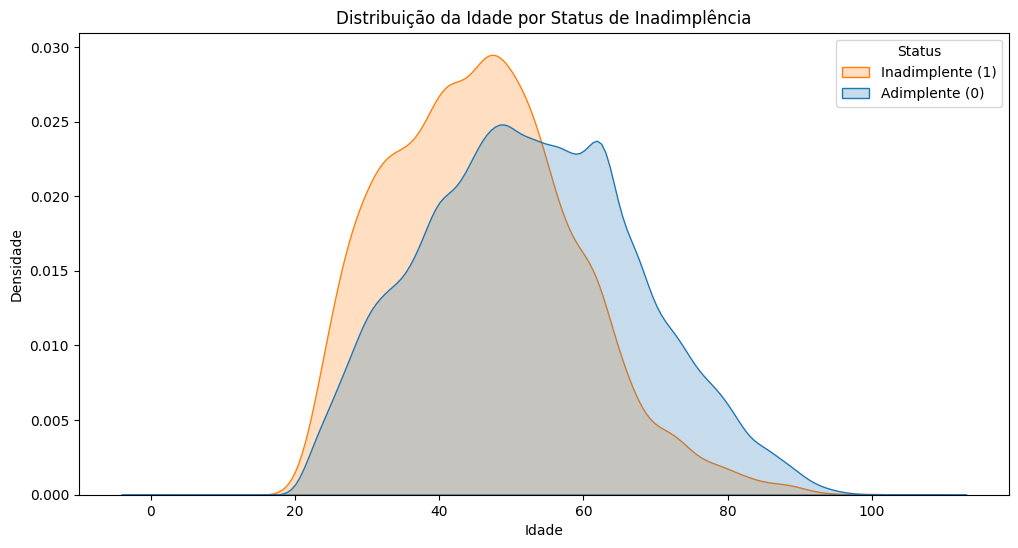

In [242]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='idade', hue='inadimplente_2_anos', fill=True, common_norm=False)
plt.title('Distribuição da Idade por Status de Inadimplência')
plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.legend(title='Status', labels=['Inadimplente (1)', 'Adimplente (0)'])
plt.show()

Pico de risco em iIdades mais jovens: A curva laranja, que representa os clientes inadimplentes, atinge seu pico em uma faixa etária mais jovem, concentrando-se visivelmente entre os 40 e 50 anos. Isso sugere que o maior volume de inadimplentes está nessa fase da vida.

Perfil adimplente mais maduro: Em contraste, a curva azul, dos clientes adimplentes, tem seu pico um pouco mais à direita, por volta dos 50 a 60 anos. Além disso, sua distribuição é mais espalhada, com uma cauda mais longa para idades mais avançadas, indicando que a adimplência é mais comum em clientes mais velhos.

Tendência geral: A conclusão mais clara é que o risco de inadimplência tende a diminuir com o avanço da idade. A probabilidade de um cliente ser inadimplente é maior nas faixas etárias mais jovens e começa a cair de forma acentuada após os 60 anos, onde a curva azul (adimplente) predomina.

Pessoas com menor renda mensal realmente têm um risco maior de inadimplência?
    
    - Análise de gráfico de violino para investigar o impacto da renda mensal no risco de crédito  

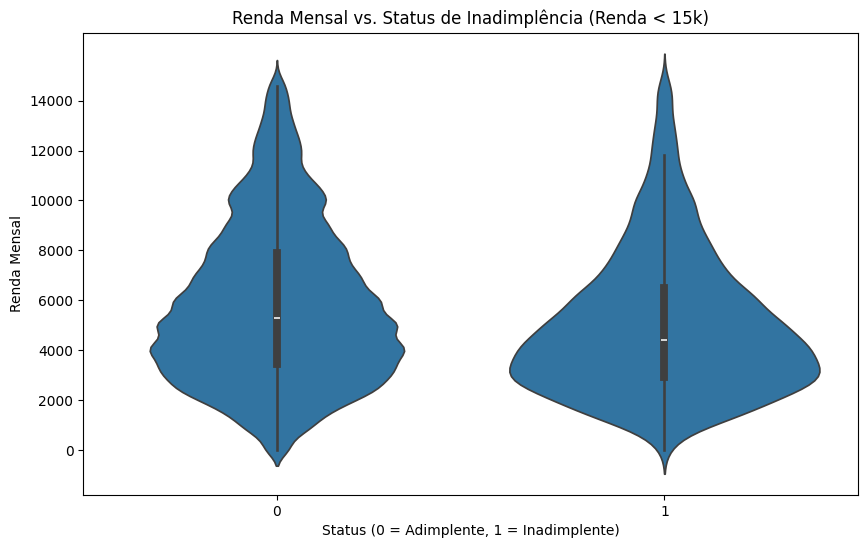

In [243]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df[(df['renda_mensal'] > 0) & (df['renda_mensal'] < 15000)],
             x='inadimplente_2_anos', y='renda_mensal')
plt.title('Renda Mensal vs. Status de Inadimplência (Renda < 15k)')
plt.xlabel('Status (0 = Adimplente, 1 = Inadimplente)')
plt.ylabel('Renda Mensal')
plt.yticks(range(0, 16000, 2000))
plt.show()

Concentração em rendas mais baixas: A forma do "violino" para ambos os grupos é mais larga na parte inferior, especialmente abaixo de R$ 8.000,00. Isso indica que a grande maioria dos clientes, tanto adimplentes quanto inadimplentes, está concentrada nas faixas de renda mais baixas.

Distribuição do risco: Embora ambos os grupos tenham clientes em todas as faixas de renda analisadas, a distribuição dos inadimplentes (1) é um pouco mais "comprimida" para baixo, com menos presença nas faixas de renda mais altas (acima de R$ 10.000,00) em comparação com os adimplentes (0).

A análise visual sugere que a renda_mensal é um indicador relevante de risco. Existe uma tendência de que clientes com menor renda mensal representam um risco de crédito mais elevado.

De qual faixa de renda se origina a maior quantidade de clientes que não pagam seus empréstimos?
    
    - Binning, contagem de inadimplentes por faixa de renda e análise gráfica

Contagem de inadimplentes por faixa de renda:
  faixa_renda  numero_de_inadimplentes
3        0-2k                      914
0       2k-4k                     2549
1       4k-6k                     2140
2       6k-8k                     1241
5      8k-10k                      657
4        >10k                      856


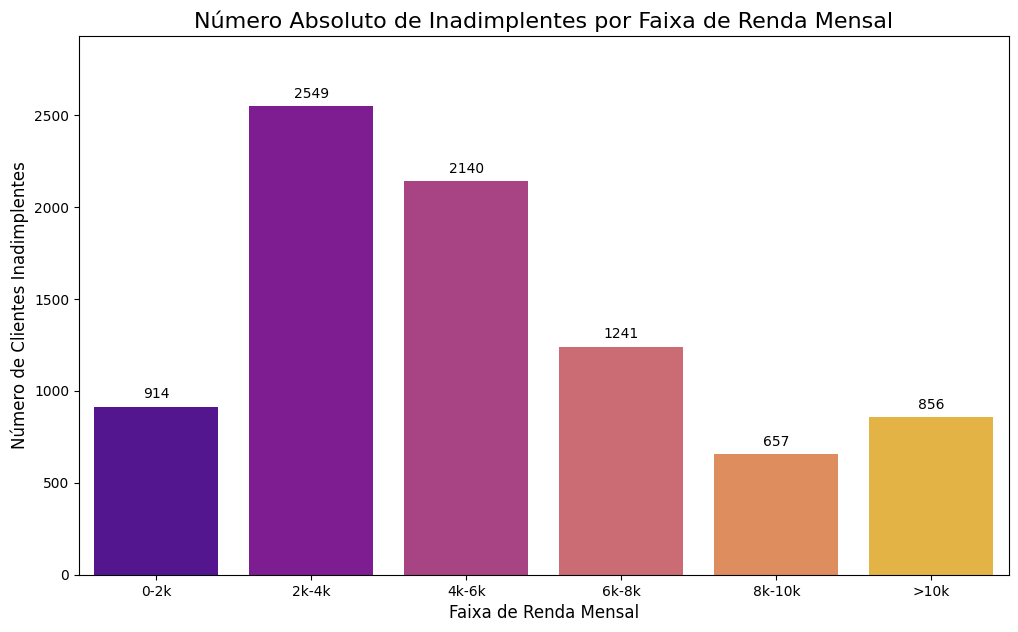

In [244]:
# Passo 1: Binning das faixas de renda
bins = [0, 2000, 4000, 6000, 8000, 10000, df['renda_mensal'].max()]
labels = ['0-2k', '2k-4k', '4k-6k', '6k-8k', '8k-10k', '>10k']
df['faixa_renda'] = pd.cut(df['renda_mensal'], bins=bins, labels=labels, right=False)


# Passo 2: Filtrar apenas os clientes inadimplentes (onde o alvo é 1)
inadimplentes_df = df[df['inadimplente_2_anos'] == 1]


# Passo 3: Contar quantos inadimplentes existem em cada faixa de renda
contagem_por_faixa = inadimplentes_df['faixa_renda'].value_counts().reset_index()
contagem_por_faixa.columns = ['faixa_renda', 'numero_de_inadimplentes']

# Ordenamos pelas faixas para que o gráfico fique na ordem correta
contagem_por_faixa = contagem_por_faixa.sort_values(by='faixa_renda')


print("Contagem de inadimplentes por faixa de renda:")
print(contagem_por_faixa)


# Passo 4: Criar o Gráfico de Barras com a contagem absoluta
plt.figure(figsize=(12, 7))

ax = sns.barplot(data=contagem_por_faixa, 
                 x='faixa_renda', 
                 y='numero_de_inadimplentes', 
                 hue='faixa_renda',  
                 palette='plasma',
                 legend=False)      

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.title('Número Absoluto de Inadimplentes por Faixa de Renda Mensal', fontsize=16)
plt.xlabel('Faixa de Renda Mensal', fontsize=12)
plt.ylabel('Número de Clientes Inadimplentes', fontsize=12)
plt.ylim(0, contagem_por_faixa['numero_de_inadimplentes'].max() * 1.15)
plt.show()

A partir do gráfico, é possível extrair os seguintes insights:

Pico de volume na faixa intermediária: Ao contrário da análise de taxa, o maior número absoluto de inadimplentes não está na faixa de renda mais baixa. O pico ocorre na faixa de R$ 4.000 a R$ 6.000 (4k-6k), com 3.809 clientes inadimplentes. A faixa de 2k-4k também contribui com um volume significativo de 2.549 inadimplentes.

Risco vs. volume: Esta análise revela uma dinâmica crucial:

Análise de taxa (risco): Mostrou que clientes de baixa renda (0-2k) têm a maior probabilidade de se tornarem inadimplentes.

Análise de contagem (volume): Mostra que o maior impacto financeiro em volume para a instituição vem das faixas de renda baixa a média (2k-6k), simplesmente porque há uma quantidade muito maior de clientes nesses segmentos.

Existe associação estatisticamente significante entre faixa de randa e 'inadimplente_2_anos'?
    
    - Teste qui-quadrado para verificar

In [245]:
# 1. Criar a Tabela de Contingência
# Esta tabela mostra a contagem de clientes para cada cruzamento de faixa de renda e status de inadimplência
tabela_contingencia = pd.crosstab(df['faixa_renda'], df['inadimplente_2_anos'])

print("--- Tabela de Contingência ---")
print(tabela_contingencia)

# 2. Rodar o Teste Qui-Quadrado
chi2, p_valor, dof, expected = chi2_contingency(tabela_contingencia)

print(f"\n--- Resultados do Teste ---")
print(f"Estatística Qui-Quadrado: {chi2:.4f}")
print(f"P-valor: {p_valor}")

# 3. Interpretar o resultado
alpha = 0.05
print(f"\nNível de significância (alpha): {alpha}")
if p_valor <= alpha:
    print("Conclusão: Rejeitamos a Hipótese Nula.")
    print(">> Existe uma associação estatisticamente significativa entre a faixa de renda e a inadimplência.")
else:
    print("Conclusão: Não conseguimos rejeitar a Hipótese Nula.")
    print(">> Não há evidências de uma associação estatisticamente significativa.")

--- Tabela de Contingência ---
inadimplente_2_anos      0     1
faixa_renda                     
0-2k                  9973   914
2k-4k                24856  2549
4k-6k                26708  2140
6k-8k                19310  1241
8k-10k               12136   657
>10k                 18928   856

--- Resultados do Teste ---
Estatística Qui-Quadrado: 581.3594
P-valor: 2.1534815746238587e-123

Nível de significância (alpha): 0.05
Conclusão: Rejeitamos a Hipótese Nula.
>> Existe uma associação estatisticamente significativa entre a faixa de renda e a inadimplência.


Qual a relação entre número de dependentes e taxa média de inadimplência?
    
    - Gráfico da taxa de inadimplência média por número de dependentes

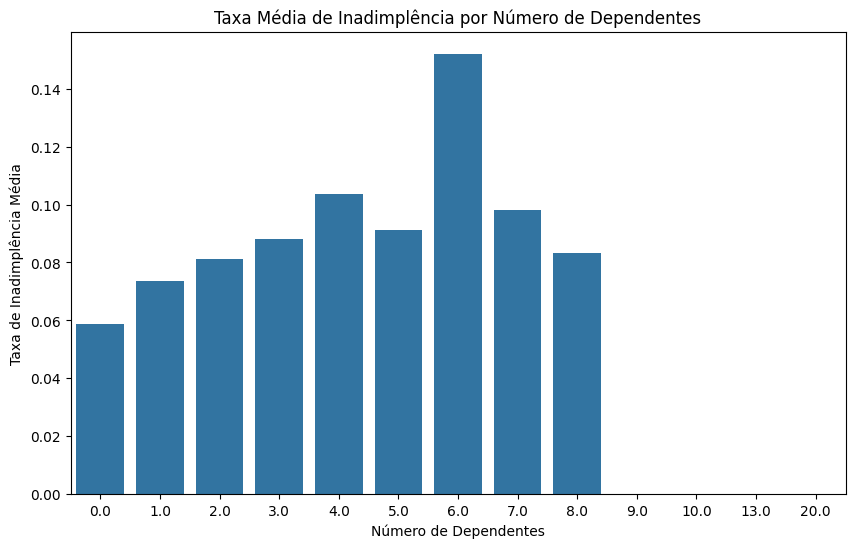

In [246]:
taxa_inadimplencia_dependentes = df.groupby('num_dependentes')['inadimplente_2_anos'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=taxa_inadimplencia_dependentes, x='num_dependentes', y='inadimplente_2_anos')
plt.title('Taxa Média de Inadimplência por Número de Dependentes')
plt.xlabel('Número de Dependentes')
plt.ylabel('Taxa de Inadimplência Média')
plt.show()

Parece que o número de dependentes é uma variavel preditiva útil. 
O gráfico mostrou uma tendência geral de aumento de risco de inadimplência conforme o número de dependentes cresce, especialmente na faixa de 0 a 4 dependentes.
- Clientes sem dependentes (0) apresentam a menor taxa de inadimplência (pouco abaixo de 6%), e essa taxa sobe de forma consistente até atingir mais de 10% para clientes com 4 dependentes. 
- A ausência de barras para 9 ou mais dependentes sugere que há poucos ou nenhum cliente com essa característica em nosso conjunto de dados. Portanto, não é possível tirar conclusões sobre o risco para famílias muito numerosas.

De forma geral, o encargo financeiro associado a um maior número de dependentes é um fator de risco claro e crescente para a inadimplência, devendo ser considerado pelo modelo de crédito.

In [247]:
# 5. Modelagem preditiva

In [248]:
# 5.1. Seleção das features

In [249]:
# y = variável alvo
y = df['inadimplente_2_anos']

# X = preditores
X = df.drop(columns=['inadimplente_2_anos'])

print("Shape de X (features):", X.shape)
print("Shape de y (alvo):", y.shape)


Shape de X (features):

 (150000, 13)
Shape de y (alvo): (150000,)


In [250]:
# 5.2. Divisão dos dados para treino/ teste

Divisão dos dados: 70% para treino e 30% para teste.
Será utilizado random_state=42, pois garante que a divisão seja sempre a mesma, o que também garante reprodutibilidade.

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [252]:
# 5.3. Seperação das variáveis númericas e categoricas

In [253]:
# Separa as colunas variáveis númericas
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Colunas Numéricas:", numeric_features)
print("Colunas Categóricas:", categorical_features)

Colunas Numéricas: ['utilizacao_credito_rotativo', 'idade', 'atraso_30_59_dias', 'razao_divida', 'renda_mensal', 'linhas_credito_abertas', 'atraso_90_dias_ou_mais', 'num_emprestimos_imobiliarios', 'atraso_60_89_dias', 'num_dependentes', 'total_atrasos_graves', 'ocorreu_atraso_grave']
Colunas Categóricas: ['faixa_renda']


Criação do pipeline de dados para encadeiamento de múltiplas etapas de pré-processamento em um único objeto, garantindo que as transformações sejam aprendidas apenas nos dados de treino e depois aplicadas de forma idêntica nos dados de teste.
- Imputação: Preenchimento dos valores ausentes com a mediana para as colunas numéricas, e com a moda para colunas categóricas.
- Escalonamento: Padronização das features numéricas colocando-as na mesma escala.
- Codificação: Transformação das categorias em variáveis numéricas que o modelo possa entender - criação de uma nova coluna binária.

In [254]:
# Pipeline para dados numéricos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para dados categóricos
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

In [255]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [256]:
# 5.4. Criação e treinamento do modelo

Criação do pipeline de pré-processamento mais o modelo. Séra utilizado parâmetro "class_weight='balance'" para melhorar o desbalanceamento dos dados.

In [257]:
# Cria o pipeline completo: pré-processamento + modelo
modelo_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])


# Treina o pipeline inteiro com os dados brutos
modelo_pipeline.fit(X_train, y_train)

# Faz predições e avaliações (o pipeline aplica todas as transformações automaticamente)
y_pred = modelo_pipeline.predict(X_test)

print("Modelo treinado com sucesso!")

Modelo treinado com sucesso!


In [258]:
# 6. Avaliação do modelo

In [259]:
# 6.1. Matriz de confusão

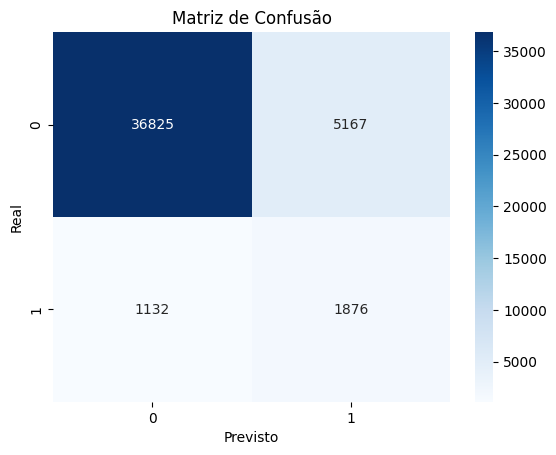

In [260]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

In [261]:
# 6.2. Relatório de classificação

In [262]:
print(classification_report(y_test, y_pred, target_names=['Adimplente (0)', 'Inadimplente (1)']))

                  precision    recall  f1-score   support

  Adimplente (0)       0.97      0.88      0.92     41992
Inadimplente (1)       0.27      0.62      0.37      3008

        accuracy                           0.86     45000
       macro avg       0.62      0.75      0.65     45000
    weighted avg       0.92      0.86      0.88     45000



In [263]:
# 6.3. Curva ROC e AUC

Pontuação AUC: 0.8195


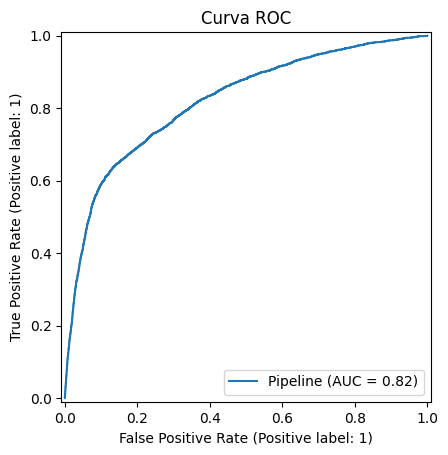

In [264]:
# Calcula a pontuação AUC
auc = roc_auc_score(y_test, modelo_pipeline.predict_proba(X_test)[:, 1])
print(f"Pontuação AUC: {auc:.4f}")

# Plota a Curva ROC
RocCurveDisplay.from_estimator(modelo_pipeline, X_test, y_test)
plt.title('Curva ROC')
plt.show()

### Análise da qualidade do modelo 
### Modelo de Regressão Logística com correção de desbalanceamento

#### Desempenho Geral

As principais métricas do modelo foram:

* **Poder de Discriminação (AUC-ROC):** O modelo demonstrou uma boa capacidade de discriminação entre as classes, com um **AUC-ROC de 0.82**.
* **Acurácia Geral:** A acurácia total do modelo foi de **86%**.
* **Recall (Sensibilidade):** O modelo identificou corretamente **62%** dos clientes que de fato se tornariam inadimplentes.
* **Precisão:** Quando o modelo previu um cliente como risco, ele estava correto em **27%** das vezes.
* **F1-Score:** A pontuação F1 para a classe de inadimplentes, que busca um balanço entre precisão e recall, foi de **0.37**.

#### Análise da Matriz de Confusão

A matriz de confusão nos permite traduzir as métricas em impacto de negócio:

* **Mitigação de Risco (Verdadeiros Positivos):** O modelo identificou corretamente **1.876** clientes inadimplentes.
* **Risco Não Detectado (Falsos Negativos):** No entanto, **1.132** clientes que se tornariam inadimplentes não foram sinalizados pelo modelo. Este é o principal risco financeiro para o negócio.
* **Custo de Oportunidade (Falsos Positivos):** O modelo classificou incorretamente **5.167** bons clientes como sendo de risco. Isso representa um custo de oportunidade, pois esses clientes poderiam ter o crédito negado ou passar por uma análise desnecessariamente rigorosa.

#### Conclusão Estratégica

O modelo ajustado funciona como um **sistema de alerta de risco moderadamente eficaz**. Ele consegue identificar a maioria dos maus pagadores (Recall de 62%), o que é positivo para a mitigação de perdas. No entanto, o custo para alcançar essa detecção é uma precisão relativamente baixa (27%), resultando em um número considerável de falsos positivos.

**Recomendação:** Este modelo pode ser utilizado para segmentar clientes para uma análise de crédito mais aprofundada, mas não para decisões automáticas de negação de crédito, devido ao alto volume de bons clientes que seriam impactados negativamente. Ele serve como um excelente baseline aprimorado para ser comparado com modelos mais complexos como Random Forest e XGBoost.

In [267]:
# 7. Interpretação dos resultados

O modelo de Regressão Logística, em sua forma atual, não é adequado para ser colocado em produção. Embora sua acurácia geral seja alta, ele falha em sua tarefa mais importante, que é mitigar o risco, resultando em um número muito elevado de Falsos Negativos, além disso, com a correção do desbalanço o modelo apresentou alto número de Falsos Positivos, 


O próximo passo:

    - Experimentar modelos mais robustos a dados desbalanceados (ex: LightGBM, XGBoost).

In [268]:
# 8. Comparação com Modelos Avançados

--- Treinando o modelo: Regressão Logística ---

--- Relatório de Classificação para Regressão Logística ---
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     41992
           1       0.27      0.62      0.37      3008

    accuracy                           0.86     45000
   macro avg       0.62      0.75      0.65     45000
weighted avg       0.92      0.86      0.88     45000

ROC AUC: 0.8195

--- Treinando o modelo: Random Forest ---

--- Relatório de Classificação para Random Forest ---
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     41992
           1       0.56      0.15      0.24      3008

    accuracy                           0.94     45000
   macro avg       0.75      0.57      0.60     45000
weighted avg       0.92      0.94      0.92     45000

ROC AUC: 0.8328

--- Treinando o modelo: XGBoost ---

--- Relatório de Classificação para XGBoost ---
              precisi

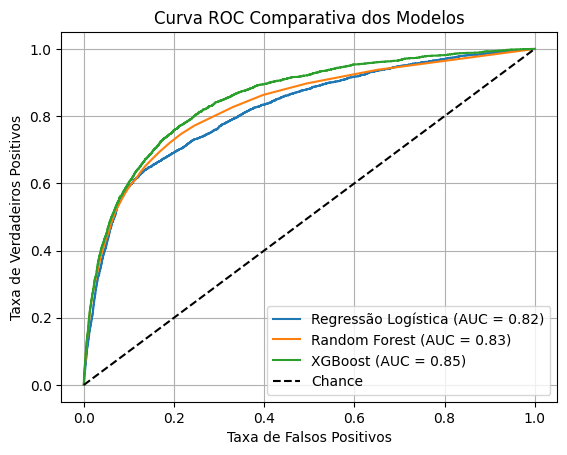

In [271]:
# Dicionário com os modelos 
# A chave é o nome do modelo, o valor é o objeto do classificador
classifiers = {
    "Regressão Logística": LogisticRegression(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# DataFrame para armazenar os resultados para comparação
results = pd.DataFrame(columns=['Modelo', 'Acurácia', 'Precisão', 'Recall', 'F1-Score', 'ROC AUC'])

# Loop para treinar e avaliar cada modelo usando o Pipeline
for name, classifier in classifiers.items():
    print(f"--- Treinando o modelo: {name} ---")

    # Cria o pipeline completo: pré-processamento + modelo da iteração atual
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)  # Insere o classificador da vez no pipeline
    ])

    # Treina o pipeline inteiro com os dados de treino
    model_pipeline.fit(X_train, y_train)

    # Faz predições no conjunto de teste
    y_pred = model_pipeline.predict(X_test)
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

    # Avalia o modelo
    print(f"\n--- Relatório de Classificação para {name} ---")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc:.4f}\n")

    # Armazena os resultados para comparação
    results = pd.concat([results, pd.DataFrame({
        'Modelo': [name],
        'Acurácia': [report['accuracy']],
        'Precisão': [report['weighted avg']['precision']],
        'Recall': [report['weighted avg']['recall']],
        'F1-Score': [report['weighted avg']['f1-score']],
        'ROC AUC': [roc_auc]
    })], ignore_index=True)

    # Plota a Curva ROC para o modelo atual
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')


# Finaliza e exibe os gráficos e a tabela comparativa
print("\n--- Tabela Comparativa de Resultados ---")

# Ordena os resultados pelo F1-Score para ver o melhor modelo
results_sorted = results.sort_values(by='F1-Score', ascending=False)
print(results_sorted)

# Configurações do gráfico da Curva ROC
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC Comparativa dos Modelos')
plt.legend(loc='best')
plt.grid()
plt.show()

## Conclusão e próximos passos

Após a análise exploratória, tratamento de dados e treinamento de três modelos distintos (Regressão Logística, Random Forest e XGBoost), o projeto atingiu seu objetivo de construir um sistema robusto para a previsão de risco de inadimplência. O ajuste da multicolinearidade se mostrou um passo crucial, resultando em um modelo de Regressão Logística mais estável e permitindo uma comparação mais justa entre os algoritmos.

### Resumo dos resultados pós-ajuste

A avaliação comparativa dos modelos revelou um claro ranking de performance, destacando a superioridade dos modelos baseados em árvore para este problema.

* **Poder de discriminação (AUC-ROC):** O **XGBoost** se consolidou como o modelo com a maior capacidade de distinguir entre bons e maus pagadores, alcançando um **AUC de 0.85**. O Random Forest apresentou um resultado próximo (0.83), enquanto a Regressão Logística aprimorada se mostrou um baseline competitivo (0.82).

* **Acurácia vs. métricas de risco:** Embora Random Forest e XGBoost tenham atingido uma acurácia superior (~94%), a análise das métricas de precisão e recall para a classe "Inadimplente" (o foco do negócio) é mais reveladora.

### Análise comparativa e escolha do modelo

A escolha do modelo ideal depende diretamente da estratégia de risco que o negócio deseja adotar, evidenciando o clássico dilema entre Precisão e Recall.

* **Regressão Logística (estratégia de detecção ampla):** Este modelo se destacou por seu alto **Recall (62%)**, identificando a maioria dos clientes que se tornariam inadimplentes. No entanto, sua **precisão foi baixa (27%)**, o que significa que muitos bons clientes seriam incorretamente sinalizados como risco (falsos positivos).
    * **Caso de uso:** Ideal para um processo de "primeiro filtro", onde todos os clientes sinalizados passam por uma análise manual mais criteriosa.

* **XGBoost e Random Forest (estratégia de alta certeza):** Ambos os modelos apresentaram **Precisão muito superior (55% e 56%, respectivamente)**, mas com um **Recall baixo (21% e 15%)**. Isso significa que, quando eles preveem um cliente como inadimplente, a chance de estarem corretos é alta. Contudo, eles falham em identificar a grande maioria dos casos de risco (falsos negativos).
    * **Caso de uso:** Adequado para decisões automatizadas de negação de crédito, mas com o risco elevado de aprovar clientes que se tornarão inadimplentes.

**Decisão final: XGBoost como modelo campeão**

O **XGBoost** é escolhido como o melhor modelo. Sua pontuação **AUC-ROC superior (0.8549)** indica que ele possui o maior potencial preditivo. Seu baixo recall atual é uma característica do limiar de decisão padrão (0.5) e pode ser ajustado para atender às necessidades do negócio, oferecendo maior flexibilidade e desempenho geral.

### Recomendações estratégicas

1.  **Implementação como ferramenta de ranking:** O modelo XGBoost deve ser implementado não como um sistema de decisão binário (aprova/nega), mas como uma **ferramenta de pontuação de risco**. Os clientes devem ser classificados de acordo com sua probabilidade de inadimplência.

2.  **Definição de limiares de ação:** Em colaboração com a área de negócios, devem ser definidos limiares de probabilidade para diferentes ações:
    * **Risco Baixo (ex: prob < 15%):** Aprovação automática.
    * **Risco Moderado (ex: 15% < prob < 40%):** Análise de crédito manual.
    * **Risco Alto (ex: prob > 40%):** Negação ou exigência de garantias adicionais.

3.  **Próximos passos para otimização:**
    * **Ajuste fino de hiperparâmetros:** Otimizar o XGBoost, especialmente o parâmetro `scale_pos_weight`, para melhorar o recall da classe minoritária de forma mais direta.
    * **Monitoramento contínuo:** Após a implementação, o modelo deve ser monitorado continuamente para avaliar seu desempenho com dados reais e ser recalibrado periodicamente para se adaptar a mudanças no comportamento do consumidor.